In [15]:
var openDigger = require('../src/open_digger');
var query = openDigger.driver.clickhouse.query;
query(
    `SHOW DATABASES`
).then(res=>{
    console.log(res);
})

[ { name: 'default' }, { name: 'github_log' }, { name: 'system' } ]


# 查询数据库所有的表

In [14]:
query(
    `SHOW TABLES from github_log`
).then(res=>{
    console.log(res);
});

[ { name: 'events' } ]


In [16]:
var repo_id = 1644196;
query(
`SELECT SUM(cnt) FROM
(
SELECT COUNT(*) as cnt FROM github_log.events WHERE repo_id = ${repo_id}
)`
).then(res => {console.log(res)});

[ { 'sum(cnt)': '439977' } ]


In [17]:
var startYear = 2015, endYear = 2021;
var startMonth = 1, endMonth = 12;
var years = [], months = [];
for (let i = startYear; i <= endYear; i++) {
    years[i - startYear] = i;
}
for (let i = startMonth; i <= endMonth; i++) {
    months[i - startMonth] = i;
}
var yms = []
for(let i = 0; i < years.length; i++) {
    for (let j = 0; j < months.length; j++) {
        yms.push({'y': years[i], 'm': months[j]});
    }
}
// 图表横坐标
yms_axis = yms.map(item => item['y'].toString() + '-' + item['m'].toString())

[
  '2015-1',  '2015-2',  '2015-3',  '2015-4',  '2015-5',
  '2015-6',  '2015-7',  '2015-8',  '2015-9',  '2015-10',
  '2015-11', '2015-12', '2016-1',  '2016-2',  '2016-3',
  '2016-4',  '2016-5',  '2016-6',  '2016-7',  '2016-8',
  '2016-9',  '2016-10', '2016-11', '2016-12', '2017-1',
  '2017-2',  '2017-3',  '2017-4',  '2017-5',  '2017-6',
  '2017-7',  '2017-8',  '2017-9',  '2017-10', '2017-11',
  '2017-12', '2018-1',  '2018-2',  '2018-3',  '2018-4',
  '2018-5',  '2018-6',  '2018-7',  '2018-8',  '2018-9',
  '2018-10', '2018-11', '2018-12', '2019-1',  '2019-2',
  '2019-3',  '2019-4',  '2019-5',  '2019-6',  '2019-7',
  '2019-8',  '2019-9',  '2019-10', '2019-11', '2019-12',
  '2020-1',  '2020-2',  '2020-3',  '2020-4',  '2020-5',
  '2020-6',  '2020-7',  '2020-8',  '2020-9',  '2020-10',
  '2020-11', '2020-12', '2021-1',  '2021-2',  '2021-3',
  '2021-4',  '2021-5',  '2021-6',  '2021-7',  '2021-8',
  '2021-9',  '2021-10', '2021-11', '2021-12'
]

# Task 1：每月新增 Star 和 Frok 的个数

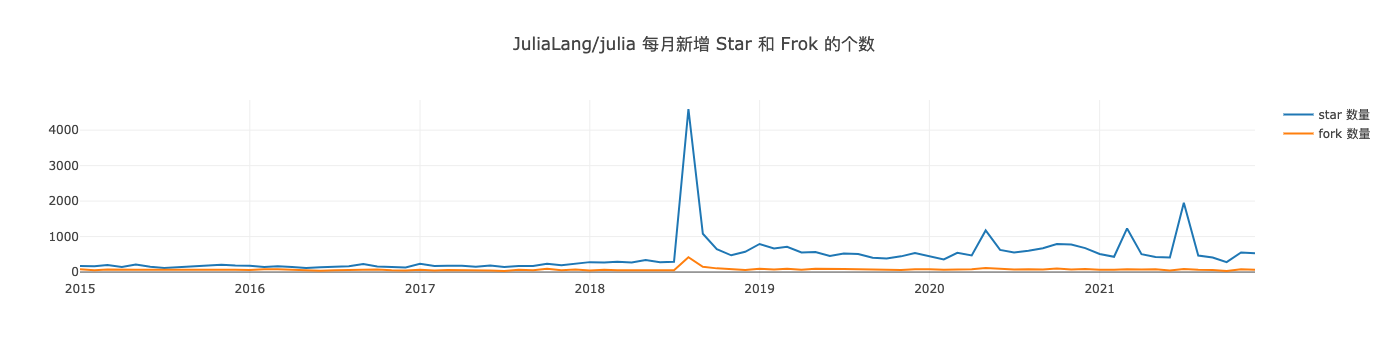

┌─────────┬───────────┬───────────┬───────────┐
│ (index) │   日期    │ star 数量 │ fork 数量 │
├─────────┼───────────┼───────────┼───────────┤
│    0    │ '2015-1'  │   '170'   │   '76'    │
│    1    │ '2015-2'  │   '164'   │   '48'    │
│    2    │ '2015-3'  │   '198'   │   '69'    │
│    3    │ '2015-4'  │   '142'   │   '58'    │
│    4    │ '2015-5'  │   '215'   │   '67'    │
│    5    │ '2015-6'  │   '149'   │   '65'    │
│    6    │ '2015-7'  │   '116'   │   '68'    │
│    7    │ '2015-8'  │   '141'   │   '61'    │
│    8    │ '2015-9'  │   '163'   │   '68'    │
│    9    │ '2015-10' │   '181'   │   '73'    │
│   10    │ '2015-11' │   '203'   │   '70'    │
│   11    │ '2015-12' │   '185'   │   '67'    │
│   12    │ '2016-1'  │   '181'   │   '56'    │
│   13    │ '2016-2'  │   '142'   │   '81'    │
│   14    │ '2016-3'  │   '161'   │   '82'    │
│   15    │ '2016-4'  │   '141'   │   '62'    │
│   16    │ '2016-5'  │   '117'   │   '60'    │
│   17    │ '2016-6'  │   '134'   │   '36'    

In [22]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id = ${repo_id} AND type = 'WatchEvent' AND toYear(created_at) = ${ym['y']} AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS star,
            count(CASE WHEN repo_id = ${repo_id} AND type='ForkEvent' AND toYear(created_at) = ${ym['y']} AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS fork
            FROM github_log.events
            `
    return query(q);
})).then(data => {
    var starCount = [], tableDict = [], forkCount = [];
    data.forEach((d, i) => {
        starCount.push(d[0].star);
        forkCount.push(d[0].fork);
        tableDict.push({'ym': yms_axis[i], 'star': starCount[starCount.length-1], 'fork': forkCount[forkCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: starCount, mode: 'scatter', name: 'star 数量'},
        {x: yms_axis, y: forkCount, mode: 'scatter', name: 'fork 数量'},
    ], {
        title: 'JuliaLang/julia 每月新增 Star 和 Frok 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            'star 数量': d.star,
            'fork 数量': d.fork,
        };
    }));
})

# Task 2: 每月打开 Issue 和 关闭 Issue 的个数

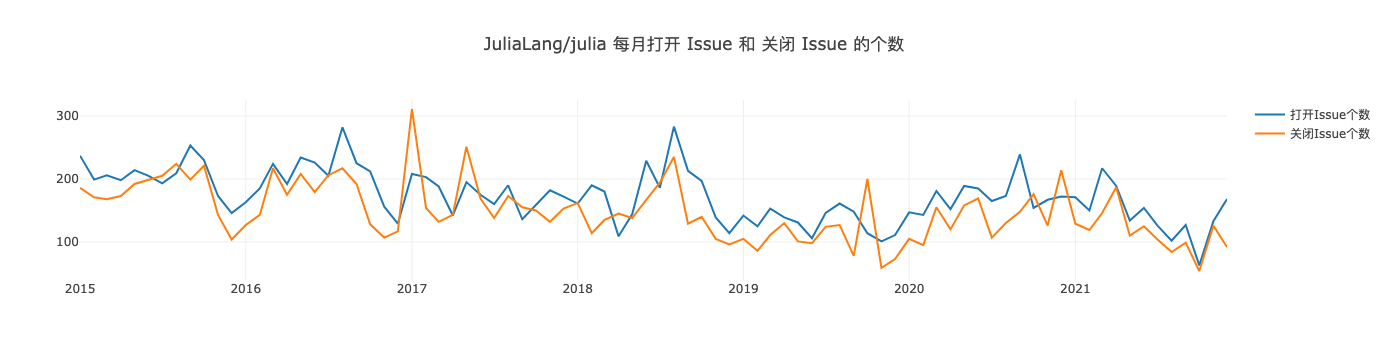

┌─────────┬───────────┬───────────────┬───────────────┐
│ (index) │   日期    │ 打开Issue个数 │ 关闭Issue个数 │
├─────────┼───────────┼───────────────┼───────────────┤
│    0    │ '2015-1'  │     '237'     │     '186'     │
│    1    │ '2015-2'  │     '199'     │     '171'     │
│    2    │ '2015-3'  │     '206'     │     '168'     │
│    3    │ '2015-4'  │     '198'     │     '173'     │
│    4    │ '2015-5'  │     '214'     │     '192'     │
│    5    │ '2015-6'  │     '205'     │     '198'     │
│    6    │ '2015-7'  │     '193'     │     '205'     │
│    7    │ '2015-8'  │     '209'     │     '224'     │
│    8    │ '2015-9'  │     '253'     │     '199'     │
│    9    │ '2015-10' │     '230'     │     '221'     │
│   10    │ '2015-11' │     '173'     │     '143'     │
│   11    │ '2015-12' │     '146'     │     '104'     │
│   12    │ '2016-1'  │     '163'     │     '127'     │
│   13    │ '2016-2'  │     '185'     │     '143'     │
│   14    │ '2016-3'  │     '224'     │     '217'     │
│ 

In [23]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id = ${repo_id} AND type = 'IssuesEvent' AND action = 'opened' AND toYear(created_at) = ${ym['y']} AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS open,
            count(CASE WHEN repo_id = ${repo_id} AND type = 'IssuesEvent' AND action = 'closed' AND toYear(created_at) = ${ym['y']} AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS close
            FROM github_log.events
            `
    return query(q);
})).then(data => {
    var openCount = [], tableDict = [], closeCount = [];
    data.forEach((d, i) => {
        openCount.push(d[0].open);
        closeCount.push(d[0].close);
        tableDict.push({'ym': yms_axis[i], 'open': openCount[openCount.length-1], 'close': closeCount[closeCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: openCount, mode: 'scatter', name: '打开Issue个数'},
        {x: yms_axis, y: closeCount, mode: 'scatter', name: '关闭Issue个数'},
    ], {
        title: 'JuliaLang/julia 每月打开 Issue 和 关闭 Issue 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '打开Issue个数': d.open,
            '关闭Issue个数': d.close,
        };
    }));
})

# Task 3：每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）

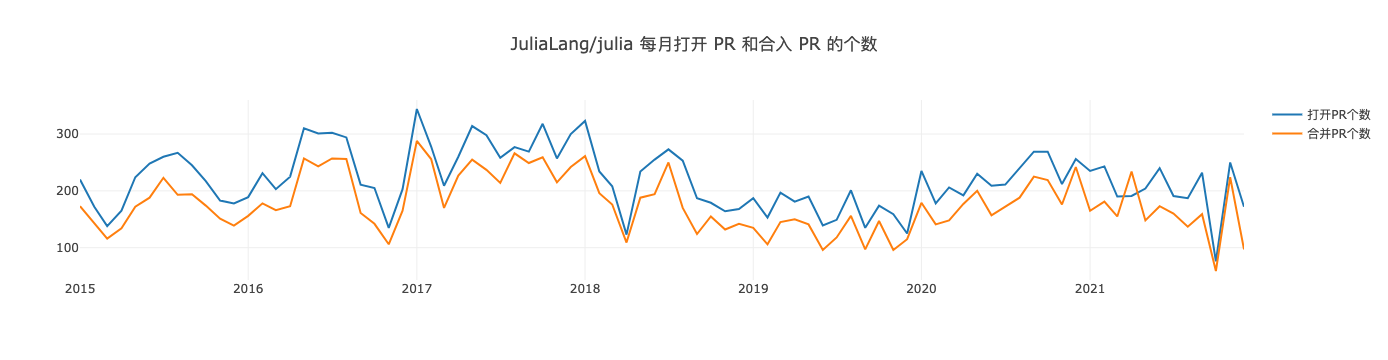

┌─────────┬───────────┬────────────┬────────────┐
│ (index) │   日期    │ 打开PR个数 │ 合并PR个数 │
├─────────┼───────────┼────────────┼────────────┤
│    0    │ '2015-1'  │   '220'    │   '173'    │
│    1    │ '2015-2'  │   '172'    │   '142'    │
│    2    │ '2015-3'  │   '138'    │   '116'    │
│    3    │ '2015-4'  │   '165'    │   '134'    │
│    4    │ '2015-5'  │   '224'    │   '172'    │
│    5    │ '2015-6'  │   '248'    │   '188'    │
│    6    │ '2015-7'  │   '260'    │   '223'    │
│    7    │ '2015-8'  │   '267'    │   '193'    │
│    8    │ '2015-9'  │   '245'    │   '194'    │
│    9    │ '2015-10' │   '217'    │   '174'    │
│   10    │ '2015-11' │   '183'    │   '151'    │
│   11    │ '2015-12' │   '178'    │   '139'    │
│   12    │ '2016-1'  │   '189'    │   '156'    │
│   13    │ '2016-2'  │   '231'    │   '178'    │
│   14    │ '2016-3'  │   '203'    │   '166'    │
│   15    │ '2016-4'  │   '225'    │   '173'    │
│   16    │ '2016-5'  │   '310'    │   '257'    │
│   17    

In [24]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'opened' AND toYear(created_at) = ${ym['y']} AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS open,
            count(CASE WHEN repo_id = ${repo_id} AND type = 'PullRequestEvent' AND pull_merged = 1 AND toYear(created_at) = ${ym['y']} AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS merge
            FROM github_log.events
            `
    return query(q);
})).then(data => {
    var openCount = [], tableDict = [], mergeCount = [];
    data.forEach((d, i) => {
        openCount.push(d[0].open);
        mergeCount.push(d[0].merge);
        tableDict.push({'ym': yms_axis[i], 'open': openCount[openCount.length-1], 'merge': mergeCount[mergeCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: openCount, mode: 'scatter', name: '打开PR个数'},
        {x: yms_axis, y: mergeCount, mode: 'scatter', name: '合并PR个数'},
    ], {
        title: 'JuliaLang/julia 每月打开 PR 和合入 PR 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '打开PR个数': d.open,
            '合并PR个数': d.merge,
        };
    }));
})

# Task 4：每月在仓库中活跃（只要有日志产生就算）的不同开发者（也就是一个GitHub账号）总数


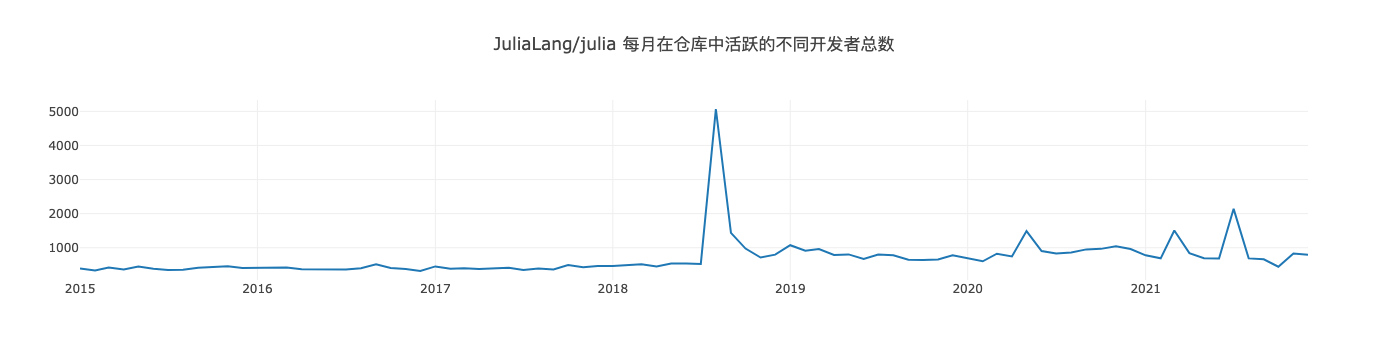

┌─────────┬───────────┬────────────┐
│ (index) │   日期    │ 开发者总数 │
├─────────┼───────────┼────────────┤
│    0    │ '2015-1'  │   '389'    │
│    1    │ '2015-2'  │   '333'    │
│    2    │ '2015-3'  │   '418'    │
│    3    │ '2015-4'  │   '361'    │
│    4    │ '2015-5'  │   '447'    │
│    5    │ '2015-6'  │   '384'    │
│    6    │ '2015-7'  │   '350'    │
│    7    │ '2015-8'  │   '354'    │
│    8    │ '2015-9'  │   '410'    │
│    9    │ '2015-10' │   '442'    │
│   10    │ '2015-11' │   '459'    │
│   11    │ '2015-12' │   '409'    │
│   12    │ '2016-1'  │   '416'    │
│   13    │ '2016-2'  │   '408'    │
│   14    │ '2016-3'  │   '419'    │
│   15    │ '2016-4'  │   '367'    │
│   16    │ '2016-5'  │   '365'    │
│   17    │ '2016-6'  │   '346'    │
│   18    │ '2016-7'  │   '365'    │
│   19    │ '2016-8'  │   '402'    │
│   20    │ '2016-9'  │   '513'    │
│   21    │ '2016-10' │   '406'    │
│   22    │ '2016-11' │   '373'    │
│   23    │ '2016-12' │   '318'    │
│   24  

In [25]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT COUNT(DISTINCT actor_id) as user
            FROM github_log.events
            WHERE repo_id = ${repo_id} AND toYear(created_at) = ${ym['y']} AND toMonth(created_at) = ${ym['m']}
            `
    return query(q);
})).then(data => {
    var userCount = [], tableDict = [];
    data.forEach((d, i) => {
        userCount.push(d[0].user);
        tableDict.push({'ym': yms_axis[i], 'user': userCount[userCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: userCount, mode: 'scatter', name: '开发者总数'},
    ], {
        title: 'JuliaLang/julia 每月在仓库中活跃的不同开发者总数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '开发者总数': d.user,
        };
    }));
})

# Task 5：Issue 从打开到关闭的平均时长和中位数（单位：天）


In [26]:
// 考虑到大部分的 Issue 都是当天打开，当前关闭，因此首先以小时为单位计算差值，再转化为天数为单位，结果更为精确
query(
    `SELECT avg(duration)/24 as avg_time, quantile(0.5)(duration)/24 as medium_time FROM (
        SELECT toRelativeHourNum(issue_closed_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.events WHERE repo_id = ${repo_id} AND type = 'IssuesEvent' AND duration >= 0
    )`
)

[ { avg_time: 218.0051121455243, medium_time: 6.895833333333333 } ]

# Task 6：PR 从打开到合入的平均时长和中位数（单位：天）


In [27]:
query(
    `SELECT avg(duration) as avg_time, quantile(0.5)(duration) as medium_time FROM(
        SELECT toRelativeHourNum(pull_merged_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.events WHERE repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'closed' and pull_merged = 1
    )`
)

[ { avg_time: 414.1995325922183, medium_time: 37 } ]

# Task 7： Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [28]:
query(
    `SELECT avg(duration)/24 as avg_time, quantile(0.5)(duration)/24 as medium_time FROM (
        SELECT toRelativeHourNum(min(issue_comment_created_at)) - toRelativeHourNum(min(issue_created_at)) AS duration  FROM (
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.events WHERE repo_id = ${repo_id} AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
         ) GROUP BY issue_id
    )`
)

[ { avg_time: 49.67023109920901, medium_time: 0.16666666666666666 } ]